In [9]:
# Numerical and plotting packages
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
import natsort
from scipy.signal import sosfiltfilt, butter, hilbert
# Libraries needed for this notebook to interact with the DANDI API
from pynwb import NWBHDF5IO
from dandi.dandiapi import DandiAPIClient
import pynwb

# Libraries needed for this notebook to interact with NWB events
from ndx_events import LabeledEvents, AnnotatedEventsTable, Events

# FSSpec is a library that allows us to read files from the cloud
import fsspec

# NWB is based on HF5, so we need this library to read NWB files
import h5py
from fsspec.implementations.cached import CachingFileSystem
import matplotlib
import os

# Data Extraction
## Getting a list paths

In [10]:
if not os.path.exists('Data'): # create Data directories
    os.mkdir('Data')

In [11]:
# Get a list of paths
with DandiAPIClient() as client:
    paths = []
    for file in client.get_dandiset("000055", "draft").get_assets_with_path_prefix(""):
        paths.append(file.path)
paths = natsort.natsorted(paths)
# print(paths)

## Access to data on cloud

In [12]:
sbj, session = '01', '3'  # participant 1, session 3
path = f'sub-0{sbj}/sub-0{sbj}_ses-{session}_behavior+ecephys.nwb'
# behavior_type = 'Eat' # only analyze data during eating
# neural_freq_range = [80, 100]  # Frequency band of interest in Hz
# ecog_ch_num = 7 # electrode number over motor cortex
# keypoint_of_interest = 'R_Wrist' # right wrist movement
# pose_direction = 'vertical'  # 'vertical' or 'horizontal'

In [13]:
from extract_utils import get_nwb
sbj_1_session_3, fs = get_nwb(sbj, session)

/Applications/anaconda3/envs/NMA/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NMA/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NMA/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.4.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [14]:
sbj_1_session_3

root pynwb.file.NWBFile at 0x27080560400
Fields:
  acquisition: {
    ECGL <class 'pynwb.base.TimeSeries'>,
    ECGR <class 'pynwb.base.TimeSeries'>,
    EOGL <class 'pynwb.base.TimeSeries'>,
    EOGR <class 'pynwb.base.TimeSeries'>,
    ElectricalSeries <class 'pynwb.ecephys.ElectricalSeries'>
  }
  devices: {
    ECG <class 'pynwb.device.Device'>,
    EOG <class 'pynwb.device.Device'>,
    GRID <class 'pynwb.device.Device'>,
    LAT <class 'pynwb.device.Device'>,
    LID <class 'pynwb.device.Device'>,
    LMT <class 'pynwb.device.Device'>,
    LPT <class 'pynwb.device.Device'>,
    LTO <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    ECG <class 'pynwb.ecephys.ElectrodeGroup'>,
    EOG <class 'pynwb.ecephys.ElectrodeGroup'>,
    GRID <class 'pynwb.ecephys.ElectrodeGroup'>,
    LAT <class 'pynwb.ecephys.ElectrodeGroup'>,
    LID <class 'pynwb.ecephys.ElectrodeGroup'>,
    LMT <class 'pynwb.ecephys.ElectrodeGroup'>,
    LPT <class 'pynwb.ecephys.ElectrodeGroup'>,
    LTO <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  epochs: epochs <class 'pynwb.epoch.TimeIntervals'>
  file_create_date: [datetime.datetime(2021, 6, 9, 5, 44, 48, 194751, tzinfo=tzoffset(None, -14400))]
  identifier: 4c571b6c-1028-476f-b0e1-e34aa27b3206
  intervals: {
    epochs <class 'pynwb.epoch.TimeIntervals'>,
    reaches <class 'pynwb.epoch.TimeIntervals'>
  }
  processing: {
    behavior <class 'pynwb.base.ProcessingModule'>
  }
  session_description: no description
  session_id: 3
  session_start_time: 2000-01-02 19:00:00-05:00
  subject: subject pynwb.file.Subject at 0x27081259712
Fields:
  species: Homo sapiens
  subject_id: 01

  timestamps_reference_time: 2000-01-02 19:00:00-05:00

### Labels


- Blocklist indicates an interruption to the video recording session. Below shows how it labels

   -  ```common_acts = [
        'Blocklist (Data break)',
        'Blocklist (Camera move/zoom)',
        'Blocklist (Camera occluded)',
        'Blocklist (Experiment)',
        'Blocklist (Private time)',
        'Blocklist (Tether/bandage)',
        'Blocklist (Hands under blanket)',
        'Blocklist (Clinical procedure)',
        ]```

    - ```common_acts = [
        'Sleep/rest',
        'Inactive',
        'Talk',
        'TV',
        'Computer/phone',
        'Eat',
        'Other activity',
        ]```

## Get Epochs

1. Retrieve dataframe with different labels and epochs time
    - `'Computer/phone' 'Eat, TV' 'Eat, Talk' 'Inactive' 'Other activity'
 'Sleep/rest' 'TV' 'Talk' 'Talk, TV'`
   - `'Blocklist (Camera move/zoom)', 'Blocklist (Data break)',
       'Blocklist (Experiment)', 'Blocklist (Private time)',
       'Blocklist (Tether/bandage)'`
2. retrieve raw data based on different behavior and subject

In [15]:
from extract_utils import get_epochs
# get epochs and labels
clabels_orig, blocklist, acts, epochs = get_epochs(sbj_1_session_3, True)
# print(clabels_orig)
# print(blocklist)
# print(acts)
# print(epochs[acts[0]])

## Extract Physiological Data from behavioural timestamps

In [16]:
from extract_utils import extract_phys_accod_timestamps
sleep_1sthour = extract_phys_accod_timestamps(sbj_1_session_3.acquisition['ElectricalSeries'].data, epochs['Eat, TV'], trange=[0, 1])

## MNI coordinates Mapping to Brain Areas

- 1.25 mm - radius of electrodesa
- convert mni coordinates to csv file to make it readable for [MNI-Talairach Converter](https://bioimagesuiteweb.github.io/webapp/mni2tal.html)


In [17]:
if not os.path.exists('Data/coords'):
    os.mkdir('Data/coords')

In [18]:
from extract_utils import mni_2_csv
eleloc = mni_2_csv(sbj_1_session_3, 1, 3, True)
eleloc = pd.read_csv('Data/coords/converted.csv')
np.unique(eleloc['BA'])

array(['Left-Broca-Operc (44)', 'Left-Broca-Triang (45)',
       'Left-Fusiform (37)', 'Left-InfTempGyrus (20)', 'Left-Insula (13)',
       'Left-MedTempGyrus (21)', 'Left-ParsOrbitalis (47)',
       'Left-PreMot+SuppMot (6)', 'Left-PrimMotor (4)',
       'Left-PrimSensory (1)', 'Left-Putamen', 'Left-SupTempGyrus (22)',
       'Left-Temporalpole (38)', 'Left-dlPFC(lat) (46)',
       'Outside defined BAs'], dtype=object)

# Plot Electrode Locations

- Using `nilearn.plot_connectome` to visualise electrode locatiions

In [19]:
import nilearn as ni
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from nilearn.plotting import plot_connectome

/Users/apple/NWA/extract_utils.py:191: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


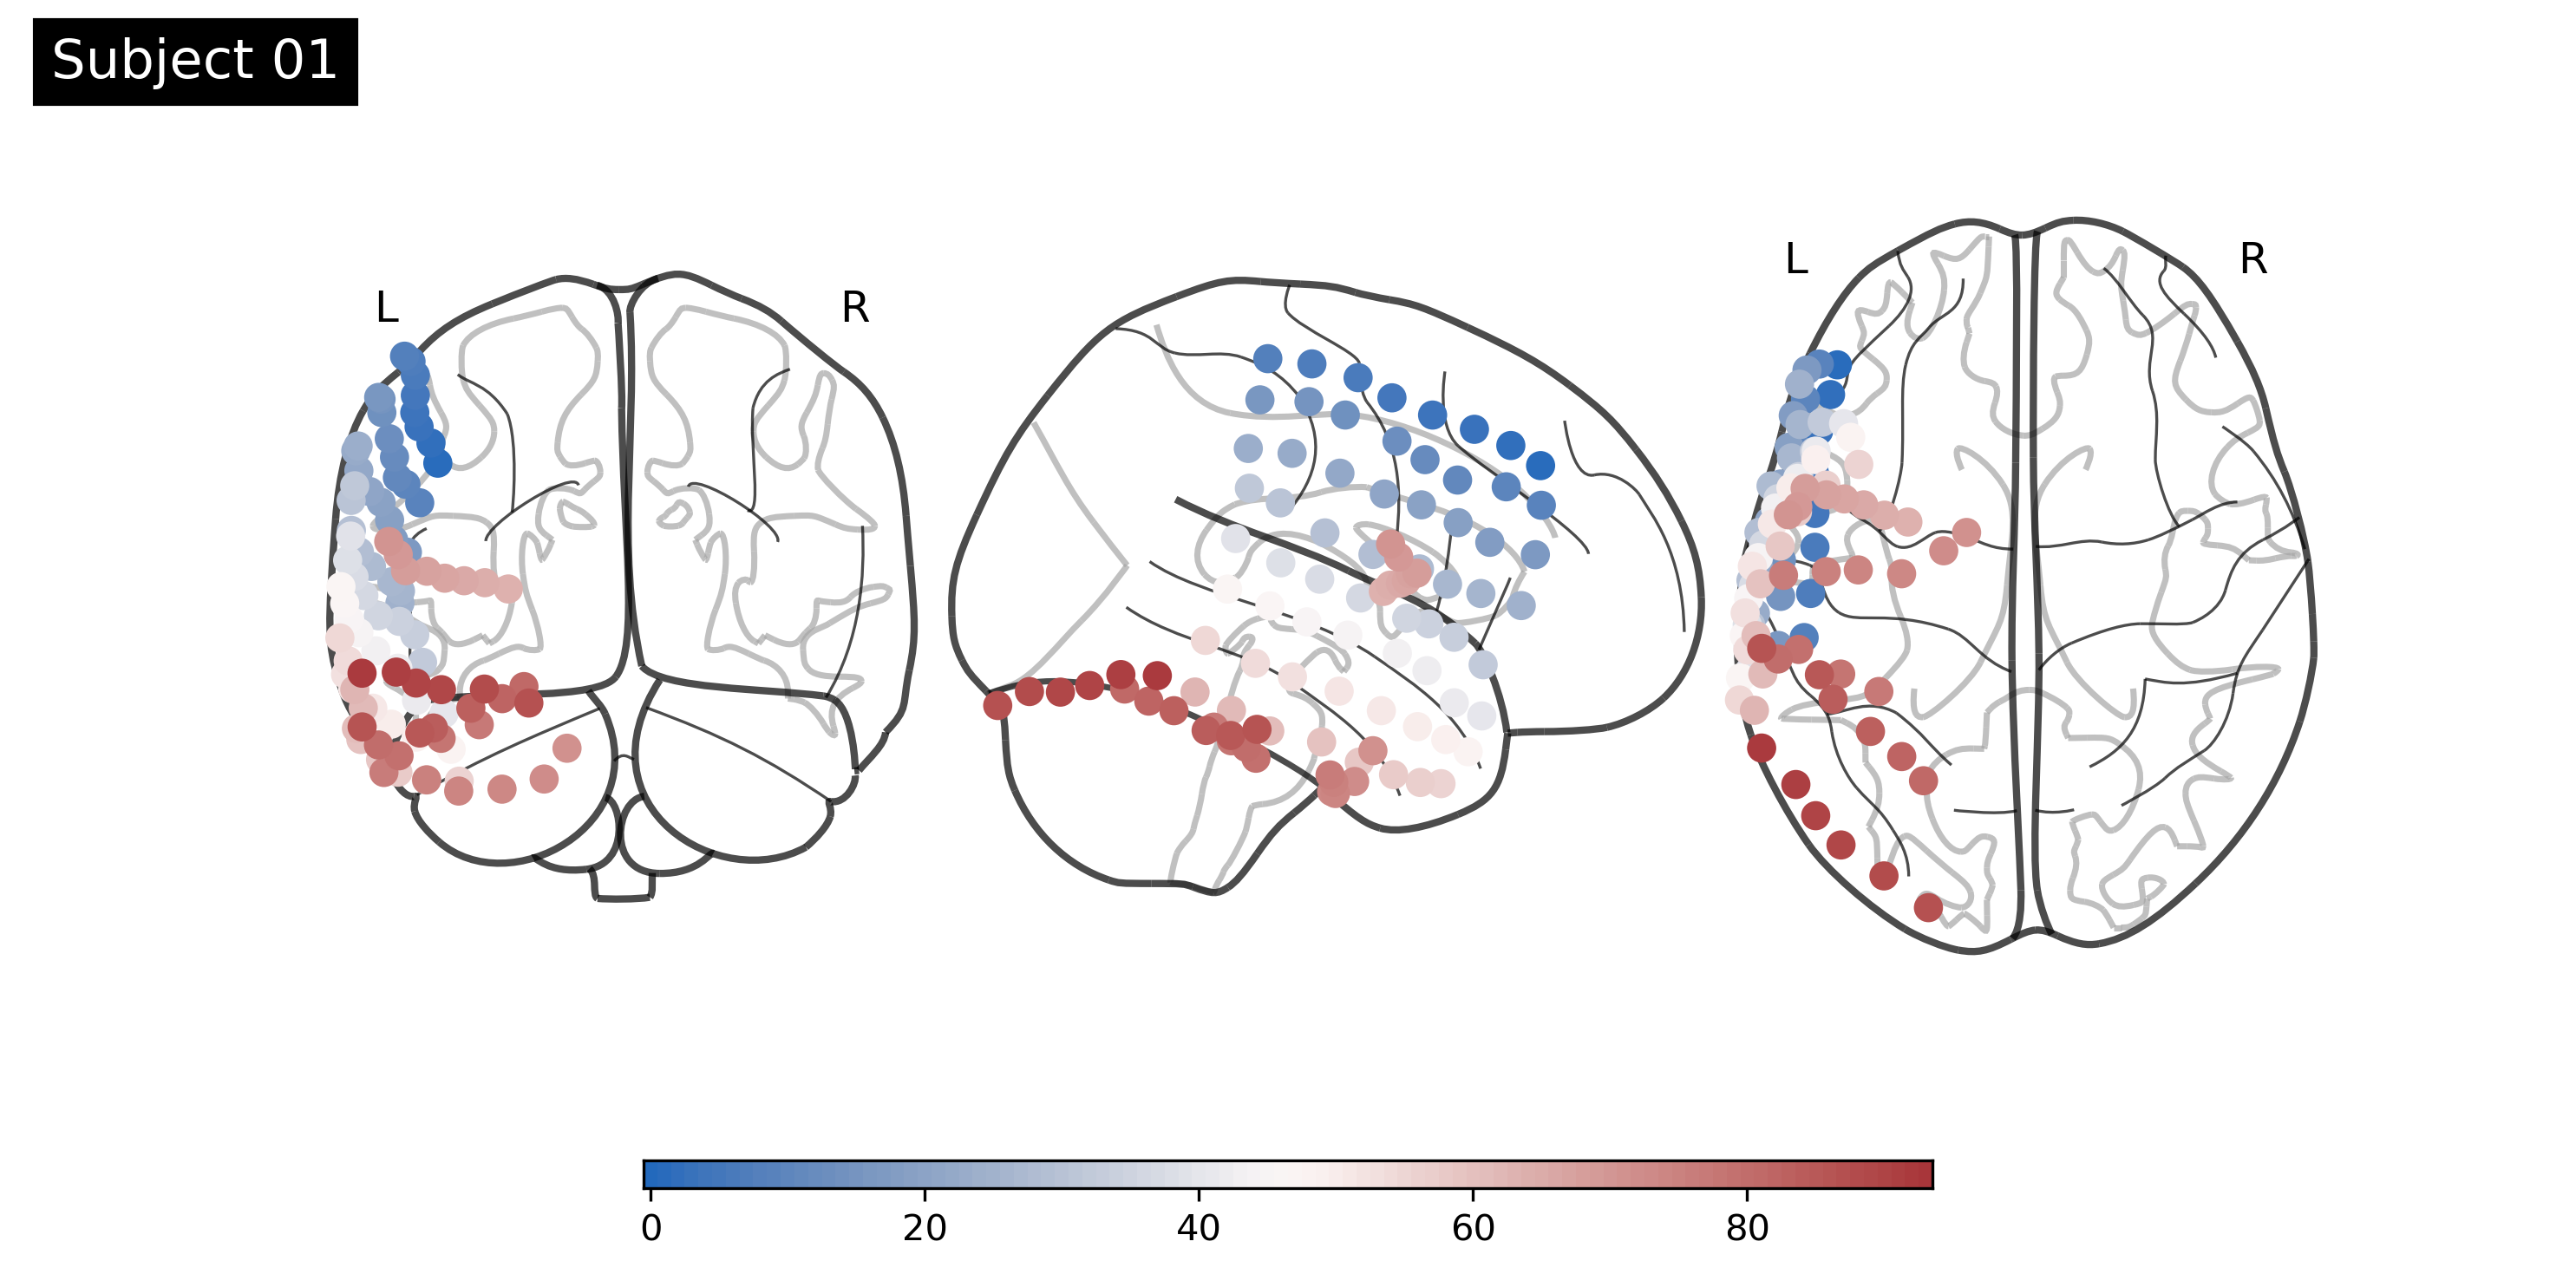

In [21]:
eleloc = sbj_1_session_3.electrodes.to_dataframe().iloc[:, 0:3]

from extract_utils import plot_electrodes
fig = plot_electrodes(eleloc, sbj)
# plt.tight_layout()